This notebook detects IEDs using different parameters.

In [1]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import math
import pyedflib
import random

matplotlib.rcParams['figure.figsize'] = (10, 2)
mne.set_log_level('WARNING')

%run DetectSpike_SEEG.py

Open the file

In [2]:
# file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
file_name = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'

f = pyedflib.EdfReader(file_name)

Define file specific parameters

In [3]:
freq = 2048
ref_chan = 'EEG 07'

Get channels and number of channels

In [4]:
num_chans = f.signals_in_file  # change to valid_channels.shape[0]
signal_labels = f.getSignalLabels()

Get list of channels to use from channels.mat

In [5]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# valid_channels = signal_labels

Process a random minute of data with a range of params and select random 5s segments in random channels to show detections for each set of params.

28 EEG I4 2


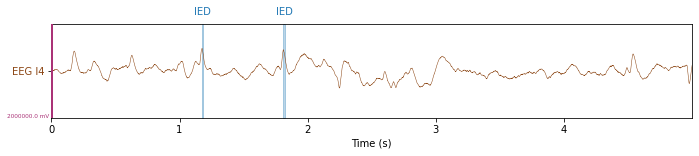

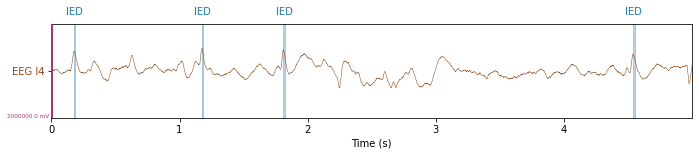

In [7]:
# Process 1 minute at a time
mins_to_process = 1

M = f.getNSamples()[0]# / (freq * 60)

NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

def generate_detections(params_list):
    
    # Randomly choose a minute to select data from
    minute = random.randrange(Blocks)
    minute = 28
    
    data_block = np.zeros((len(valid_channels), freq * 60 * mins_to_process))

#     reference = f.readSignal(signal_labels.index(ref_chan), \
#                              start = minute * freq * 60 * mins_to_process, \
#                              n = freq * 60 * mins_to_process)

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = minute * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process)# - reference
        
    # Index of channel to consider
    chan = random.choices(valid_channels)[0]
    chan = 'EEG I4'
    
    # Randomly select a 5 second segment within the minute of data to show detections for (note: 12 blocks of 5s)
    five_second_segment = random.randrange(12)
    five_second_segment = 2
    
    print(minute, chan, five_second_segment)
    
    for params in params_list:
        # Detect IEDs in current block across all chanels
        SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq, **params)

        info = mne.create_info([chan], freq, ch_types='seeg')
        data = mne.io.RawArray(data = [data_block[valid_channels.index(chan)] \
                                       [five_second_segment * freq * 5 : \
                                        (five_second_segment + 1) * freq * 5]], info = info)

        onsets = []
        durations = []
        descriptions = []
        
        SpikeIds_from_zero = SpikeIndex - five_second_segment * freq * 5
        spike_indices = np.logical_and(ChanId == valid_channels.index(chan), SpikeIds_from_zero < 5 * freq)
        
        for spike in SpikeIds_from_zero[spike_indices]:
            if spike > 0:
                onsets.append(spike / 2048)
                durations.append(0.01)
                descriptions.append('IED')

        my_annot = mne.Annotations(onset=onsets,  # in seconds
                                   duration=durations,  # in seconds, too
                                   description=descriptions)

        data = data.set_annotations(my_annot)

        # test = data.plot(start=20, duration=2, n_channels=6, scalings=dict(eeg=5e-4))
        fig = data.plot(scalings=dict(seeg=1e3), show_scrollbars=False)

        plt.show()
        
DetThresholds_list = [[7, 7, 200, 10, 10],
                      [7, 7, 400, 10, 10],
                      [7, 7, 600, 10, 10],
                      [7, 7, 800, 10, 10]]

STDCoeff_list = [2, 3]

SCALE_list = [70]

params1 = {'STDCoeff': 5, 'SCALE': 90, 'TroughSearch': 50}
params2 = {'STDCoeff': 3}

# generate_detections(DetThresholds_list)
generate_detections([params1, params2])

Det Thresholds: [7, 7, 600, 10, 10]

7 seems fine for the first two arguments. Definitely not 9. (explored 5-9)

STDCoeff: 3 seems okay (explored 2-6). 2 has less false negatives, but more false positives.

scales of 60-90 so far (explored 50-90). 70 seems good.